<a href="https://colab.research.google.com/github/NeilTheFisher/COMP432/blob/main/labs/Lab7_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Week 7 - Hyperparameter Search

In this lab, you'll use *cross-validation* to do a *hyperparameter search*.

* **Validation (or cross-validation)** is a procedure for *estimating* the test-time performance of a given model. Cross-validation does not need access to any test data. Instead, it works by holding out some of the training data and using it as if it were testing data. In this lab, we will focus on *K*-fold cross-validation, where the training data is divided into *K* equally-sized chunks and each chunk gets a turn "pretending" to be a test set. The way to implement it will be explained later.
* **Hyperparameter search** attempts to select the model that we can *expect* to have the best test-time performance. In particular, *Hyperparameter search* focuses on finding proper values for the most important hyperparameters of the model. For instance, for a Multi-Layer Perceptron (MLP), a hyperparameter search would find the set of hyperparameters (e.g., learning rate, number of neurons, etc) that is estimated to have the best possible test-time performance using validation data (*not* the test data directly!). This lab will show how to do hyperparameter search using scikit learn.


**Run the code cell below** to import the required packages.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.svm               # For SVC
import sklearn.tree              # For DecisionTreeClassifier
import sklearn.metrics           # For accuracy_score
import sklearn.model_selection   # For cross_val_score, GridSearchCV, RandomizedSearchCV
import scipy
import scipy.stats               # For reciprocal distribution
import warnings

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 1. Understanding Cross-Validation

Exercise 1.1&ndash;1.3 asks you to load and preprocess the training data (**data.csv**). Then, you have to split the data into a training set and held-out test set (**[sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)**). Finally, you have to compare how *K*-fold cross-validation can estimate the held-out test performance of a model.

**Run the code cell below** to download the dataset used for this lab, and defining the data plotting functions.

In [2]:
def draw_plot(X, y):
    """Plots the data from Exercise 1"""
    plt.scatter(*X[y==0].T, marker="x", c="r")
    plt.scatter(*X[y==1].T, marker="x", c="b")
    plt.xlim([X[:,0].min(), X[:,0].max()])
    plt.ylim([X[:,1].min(), X[:,1].max()])
    plt.gca().set_aspect('equal')

def draw_dec_boundaries(X, Y, model, h = 0.02):
    """Plots the data with the decision boundaries"""

    # create a mesh to plot in
    x1min = X[:,0].min()
    x1max = X[:,0].max()
    x2min = X[:,1].min()
    x2max = X[:,1].max()

    xx1, xx2 = np.meshgrid(np.arange(x1min, x1max, h), np.arange(x2min, x2max, h))
    X_grid = np.vstack([xx1.ravel(),xx2.ravel()]).T
    probs = model.predict(X_grid)
    y_pred_grid = probs  > 0.5
    y_pred_grid = y_pred_grid.reshape(xx1.shape)
    cs = plt.contourf(xx1, xx2, y_pred_grid, cmap=plt.cm.Pastel2)

# Avoid redownloading data every run
if 'data.csv' not in os.listdir():
  # Download data:
  !wget -O data.csv https://www.dropbox.com/scl/fi/wixidt0abkltx6xy6s78l/data.csv?rlkey=e7y8e6qjuc9hujpbls1ykqhh2&dl=0


--2025-03-17 03:04:47--  https://www.dropbox.com/scl/fi/wixidt0abkltx6xy6s78l/data.csv?rlkey=e7y8e6qjuc9hujpbls1ykqhh2
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb4cf65e5970af881f7ae7c6850.dl.dropboxusercontent.com/cd/0/inline/CmC8kSGwIG74jrjrQjr5GXTDMsCzq_qmO2hp2NXGSHKYzfxtGcRkD5ZmT1r3X2wViWAk1pVj0o6kzBRltx6Wqs5cVN8risrgarBb9FNLUHSyKI-Xc9frZPpsHSad39s_cMPxBHGwDUmfzroIkBLvJKVg/file# [following]
--2025-03-17 03:04:48--  https://ucb4cf65e5970af881f7ae7c6850.dl.dropboxusercontent.com/cd/0/inline/CmC8kSGwIG74jrjrQjr5GXTDMsCzq_qmO2hp2NXGSHKYzfxtGcRkD5ZmT1r3X2wViWAk1pVj0o6kzBRltx6Wqs5cVN8risrgarBb9FNLUHSyKI-Xc9frZPpsHSad39s_cMPxBHGwDUmfzroIkBLvJKVg/file
Resolving ucb4cf65e5970af881f7ae7c6850.dl.dropboxusercontent.com (ucb4cf65e5970af881f7ae7c6850.dl.dropboxusercontent.com)... 162.125.5.15, 2620:100:6

<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.1 &mdash;  Load, re-scale, and plot full data set

The data is available in the file `data.csv`.

Start by loading the data with `np.loadtxt`. Then, seperate the data in features X and labels y.  Plot the data using **draw_plot()** function.


Your plot should look like the figure below.

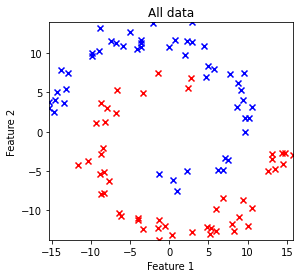

**Complete the code below** to read the data.

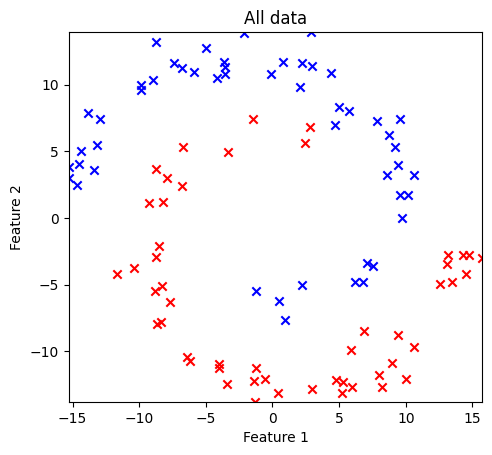

In [4]:
# Load the data (aim for 1 line)
data = np.loadtxt('data.csv', delimiter=',', skiprows=1)

# Split the data (aim for 1 line)
X, y = data[:, :-1], data[:, -1]

# Plot the data
draw_plot(X, y)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title('All data');

**Check** your answer by running the following code:

In [5]:
assert 'X' in globals(), "No X variable!"
assert 'y' in globals(), "No y variable!"
assert isinstance(X, np.ndarray)
assert isinstance(y, np.ndarray)
assert X.shape == (100, 2)
assert y.shape == (100,)
assert X.dtype == np.float64
assert y.dtype == np.float64
assert X[0,0]==-5.87495, "Hmm features look wrong"
assert X[0,1]==10.93091, "Hmm features look wrong"
assert X[99,0]==-13.38376, "Hmm features look wrong"
assert X[99,1]==3.5999, "Hmm features look wrong"
print("Correct!")

Correct!


<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.2 &mdash;  Split data to training and testing
In this exercise, you should use  **[sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)** to split the data from Exercise 1.1 into two groups: a training set, and a held-out test set. Use *random_state*=1. For this exercise, you should explicitly ask for a 75/25 split (75% training data, 25% testing data). Then, pre-process the data to the right scale using `sklearn.preprocessing.StandardScaler` (make sure to normalize the test set using the statistics from the training set). Plot the training and test data sets side-by-side, using the *draw_plot* function defined above and the  *subplot* function of Matplotlib. You should get the following image:


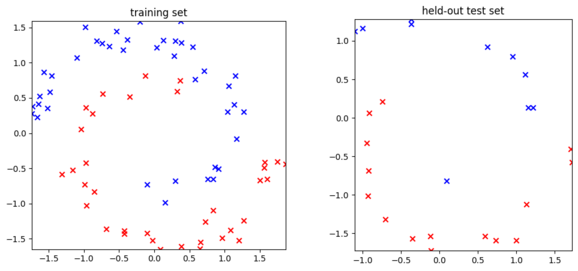

**Complete the code below** to implement what describe above:

(-1.6, 1.6)

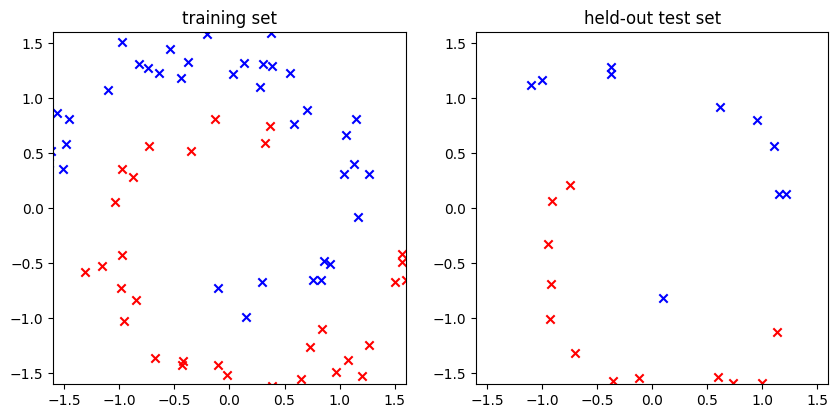

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split train and test data (aim for 1 line)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# Normalization (aim for 3 lines)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Plot training and test data (aim for 6-7 lines)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
draw_plot(X_train, y_train)
plt.title('training set')
plt.xlim(-1.6, 1.6)
plt.ylim(-1.6, 1.6)

plt.subplot(1, 2, 2)
draw_plot(X_test, y_test)
plt.title('held-out test set')
plt.xlim(-1.6, 1.6)
plt.ylim(-1.6, 1.6)

Check your answer by running the following code:

In [ ]:
assert 'X_train' in globals(), "No X_train variable!"
assert 'y_train' in globals(), "No y_train variable!"
assert 'X_test' in globals(), "No X_test variable!"
assert 'y_test' in globals(), "No y_test variable!"
assert isinstance(X_train, np.ndarray)
assert isinstance(y_train, np.ndarray)
assert isinstance(X_test, np.ndarray)
assert isinstance(y_test, np.ndarray)
assert X_train.shape == (75, 2)
assert y_train.shape == (75,)
assert X_test.shape == (25, 2)
assert y_test.shape == (25,)
assert X_train.dtype == np.float64
assert y_train.dtype == np.float64
assert X_test.dtype == np.float64
assert y_test.dtype == np.float64
assert X_train[0,0]==-1.162427720353385, "Hmm features look wrong"
assert X_test[0,0]==-0.9298070080212323, "Hmm features look wrong"
assert X_train[-1,0]==-1.1035936112168572, "Hmm features look wrong"
assert X_test[-1,0]==1.7231523821982997, "Hmm features look wrong"
assert y_train[0]==0.0, "Hmm features look wrong"
assert y_test[0]==0.0, "Hmm features look wrong"
assert y_train[-1]==1.0, "Hmm features look wrong"
assert y_test[-1]==0.0, "Hmm features look wrong"
print("Correct!")

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

### Exercise 1.3 &mdash; Use *K*-fold cross-validation to *estimate* held-out performance

As a rule, data marked as a "test set" should **NEVER** be used for training, or even for hyperparameter tuning. The parameters of the model (e.g., the weights of a linear transformation or the filters of a convolutional neural network) are learned on training data, ONLY. Otherwise, you will very likely fool yourself, or others, into thinking your system will perform well on held-out data when it will not. The hyperparameters (e.g., learning rate, batch size, number of neurons, etc.) are tuned on the validation data (that are typically extracted from the training data).
Using the test data for hyperparameter tuning is another bad machine learning practice. Even measuring the performance on test data too often, is considered cheating.

*What is K-fold cross-validation?*
***K*-fold cross-validation** is a specific procedure for estimating held-out test performance using only the training set. It works in this way:
1. First, we have to create *K* different (training, validation) splits.
2. We then have to average the validation performance measured on each split. This will provide an estimation of the performance that you can expect from the test data. (Beware that scikit-learn's [desciption of cross validation](https://scikit-learn.org/stable/modules/cross_validation.html#k-fold) sometimes refers to the *K* individual validation sets as "test sets" so this can be confusing since they are not really validation sets.).
The *K*-fold cross-validation procedure is depicted below. When there are *K* splits the result is *K* different performance estimates, one for each of the held-out folds.



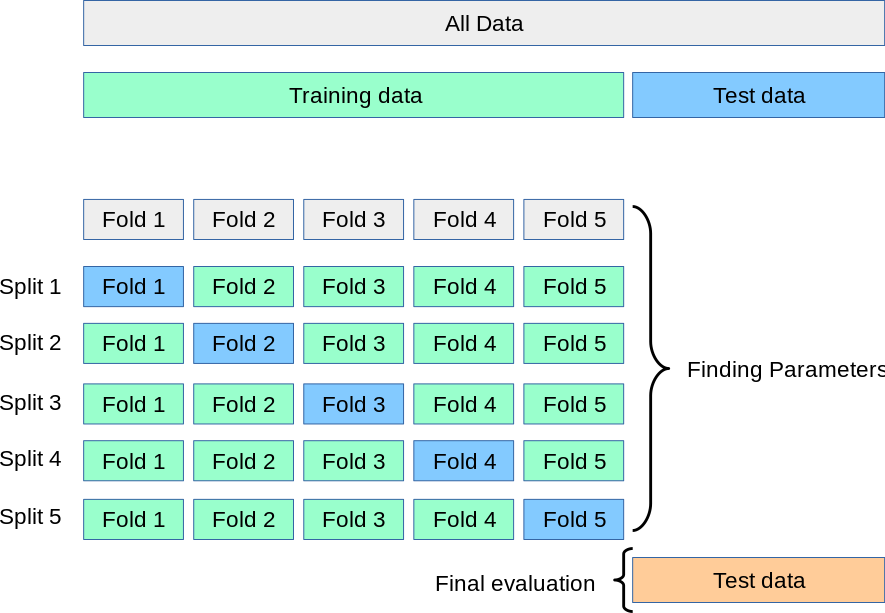

**Write a few lines of code** to:
1. Train an MLP *classifier* (using scikit learn) with a single hidden layer composed of 5 neurons, ReLU activation, adam optimizer,  batch_size of 32 samples, 3500 iterations max, learning_rate_init of 0.004, and  random_state set to 1.
2. Print the accuracy on the training and test set from Exercise 1.2.
2. Print the *K*-fold cross-validation accuracy for each $K \in \{2,\ldots,9\}$.

Use the **[sklearn.model_selection.cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)** function to do the cross-validation. It will return an array of *K* values, so you need to average them to get an overall estimate. Use the option `cv` to select the number of folds.

Your code should print output that looks like this:

```
training accuracy:           100.0%
held-out accuracy (testing):  --.-%
held-out accuracy (2-fold):   --.-%
held-out accuracy (3-fold):   --.-%
held-out accuracy (4-fold):   --.-%
held-out accuracy (5-fold):   --.-%
held-out accuracy (6-fold):   --.-%
held-out accuracy (7-fold):   --.-%
held-out accuracy (8-fold):   --.-%
held-out accuracy (9-fold):   --.-%
```

**Complete the code below**:

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# Instantiate an MLP (aim for 1 line)
mlp = MLPClassifier(hidden_layer_sizes=(5,), activation='relu', solver='adam', batch_size=32, max_iter=3500, learning_rate_init=0.004, random_state=1)

# Train the MLP aim for 1 line)
mlp.fit(X_train, y_train)

# Print training and test accuracies (aim for 2 lines)
print(f"training accuracy:  {mlp.score(X_train, y_train) * 100:.1f}%")
print(f"held-out accuracy (testing):  {mlp.score(X_test, y_test) * 100:.1f}%")

# Loop over k-folds
for k in range(2,10):
    scores = sklearn.model_selection.cross_val_score(mlp, X_train, y_train, cv=k)
    print("held-out accuracy (%d-fold):   %.1f%%" % (k, scores.mean()*100))

training accuracy:  96.0%
held-out accuracy (testing):  100.0%
held-out accuracy (2-fold):   74.8%
held-out accuracy (3-fold):   90.7%
held-out accuracy (4-fold):   92.0%
held-out accuracy (5-fold):   93.3%
held-out accuracy (6-fold):   93.4%
held-out accuracy (7-fold):   90.6%
held-out accuracy (8-fold):   77.6%
held-out accuracy (9-fold):   80.2%


As you can see the *K*-fold cross-validation accuracies only provide a "reasonable" estimate of the testing accuracy. At least, you can see that this estimate is much better than that provided by the *training* accuracy.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 2. Hyperparameter search
We can now tune some of the hyperparameters of the model. In particular, for simplicity, we are going to focus on the learning rate and the number of neurons in the hidden layer only.

Exercise 2.1 asks you to plot the MLP model with different hyperparameters, this would help you to visualize the grid of hyperparameters.

Exercise 2.2 asks you to perform grid search using **[sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)**.

Exercise 2.3 asks you to perform a random hyperparameter search.

Exercise 2.4 asks you to evaluate the model selected from exercises 1.4 and 1.5 on the held-out test set.



<div style="border-bottom: 3px solid black;"></div>

### Exercise 2.1 &mdash; Visualize a grid of hyperparameters

In this exercise, you need to train an MLP on the training data using different hyperparameter settings. The specific hyperparameters that you will inspect are *learning_rate_init* (the learning rate) and the *hidden_layer_sizes* (the neurons of the hidden layer).

**Step 1. Create a 4x4 grid made from 4 distinct learning rate values and 4 distinct *neurons* values.**

In particular, you can use a grid with the following four learning rates: 4, 0.4, 0.4,0.004 and the following four numbers of neurons: 2,8,16,32.
You can use `np.array` to define these values.

**Complete** the code below to set up a grid of hyperparameters:

In [65]:
# Your code here. Aim for 3 lines, plus lines for printing the values, if it helps you.
learning_rates = np.array([4, 0.4, 0.04, 0.004])
neurons = np.array([2, 8, 16, 32])
lr_grid, neuron_grid = np.meshgrid(learning_rates, neurons)


print("lr grid", lr_grid)
print("neuron grid", neuron_grid)
print([x for x in zip(lr_grid.flatten(), neuron_grid.flatten())])



lr grid [[4.    0.4   0.04  0.004]
 [4.    0.4   0.04  0.004]
 [4.    0.4   0.04  0.004]
 [4.    0.4   0.04  0.004]]
neuron grid [[ 2  2  2  2]
 [ 8  8  8  8]
 [16 16 16 16]
 [32 32 32 32]]
[(4.0, 2), (0.4, 2), (0.04, 2), (0.004, 2), (4.0, 8), (0.4, 8), (0.04, 8), (0.004, 8), (4.0, 16), (0.4, 16), (0.04, 16), (0.004, 16), (4.0, 32), (0.4, 32), (0.04, 32), (0.004, 32)]


**Step 2. Print the training accuracy of an MLP for each setting in the grid**

Use for-loops to train an MLP for each combination of (*lr*, *neurons*) in your grid, using the variables you already created in the previous code cell. For this exercise, we derive a single training-validation split (1-fold): the training data should contain 50 samples, while the validation data the remaning 20.

Train the MLPs on the *X_tr* and *y_tr* data from exercise 1.2.
Remember that you can get the accuracy on the validation set using the method `.score` of the MLP object applied to *X_valid* and *y_valid*. Apart from the learning rate and the number of neurons, use the same hyperparameters mentioned above in Exercise 1.3.

The output of your code cell should be something like:
```
72.0% validation accuracy for lr=4.000 neurons=2
68.0% validation accuracy for lr=4.000 neurons=8
84.0% validation accuracy for lr=4.000 neurons=16
84.0% validation accuracy for lr=4.000 neurons=32
96.0% validation accuracy for lr=0.400 neurons=2
88.0% validation accuracy for lr=0.400 neurons=8
96.0% validation accuracy for lr=0.400 neurons=16
100.0% validation accuracy for lr=0.400 neurons=32
96.0% validation accuracy for lr=0.040 neurons=2
96.0% validation accuracy for lr=0.040 neurons=8
100.0% validation accuracy for lr=0.040 neurons=16
100.0% validation accuracy for lr=0.040 neurons=32
96.0% validation accuracy for lr=0.004 neurons=2
96.0% validation accuracy for lr=0.004 neurons=8
100.0% validation accuracy for lr=0.004 neurons=16
88.0% validation accuracy for lr=0.004 neurons=32
```


**Complete** the code below to train an MLP for each setting in the grid:

In [41]:
from sklearn.neural_network import MLPClassifier

# Get validation data
X_tr= X_train[0:50]
y_tr= y_train[0:50]
X_valid = X_train[50:]
y_valid = y_train[50:]

# Your code here. Aim for 6-10 lines.
for lr, neurons in zip(lr_grid.flatten(), neuron_grid.flatten()):
    mlp = MLPClassifier(hidden_layer_sizes=(neurons,),
                        learning_rate_init=lr,
                        max_iter=10_000,
                        random_state=42)
    mlp.fit(X_tr, y_tr)
    accuracy = mlp.score(X_valid, y_valid)
    print(f"{accuracy * 100:.1f}% validation accuracy for lr={lr:.3f} neurons-{neurons}")


32.0% validation accuracy for lr=4.000 neurons-2
76.0% validation accuracy for lr=0.400 neurons-2
72.0% validation accuracy for lr=0.040 neurons-2
72.0% validation accuracy for lr=0.004 neurons-2
80.0% validation accuracy for lr=4.000 neurons-8
100.0% validation accuracy for lr=0.400 neurons-8
100.0% validation accuracy for lr=0.040 neurons-8
100.0% validation accuracy for lr=0.004 neurons-8
64.0% validation accuracy for lr=4.000 neurons-16
100.0% validation accuracy for lr=0.400 neurons-16
100.0% validation accuracy for lr=0.040 neurons-16
100.0% validation accuracy for lr=0.004 neurons-16
60.0% validation accuracy for lr=4.000 neurons-32
100.0% validation accuracy for lr=0.400 neurons-32
100.0% validation accuracy for lr=0.040 neurons-32
100.0% validation accuracy for lr=0.004 neurons-32


Based on the validation accuracy, we can already have an idea about which hyperparameter setting works the best. In the next exercise, you will plot the solutions explored during the grid search. This will give you some better insights into the best set of hyperparameters.

**Step 3. Plot the decision function for each setting in the grid**

Repeat step 2 but instead of printing accuracies, you should instead plot the data (use **draw_plot**) and the decision function of the trained model (use **draw_dec_boundaries**). You must create a single figure with 16 subplots arranged in a 4x4 grid, one for each (*lr*, neurons*) hyperparameter setting.

You should see the following image:

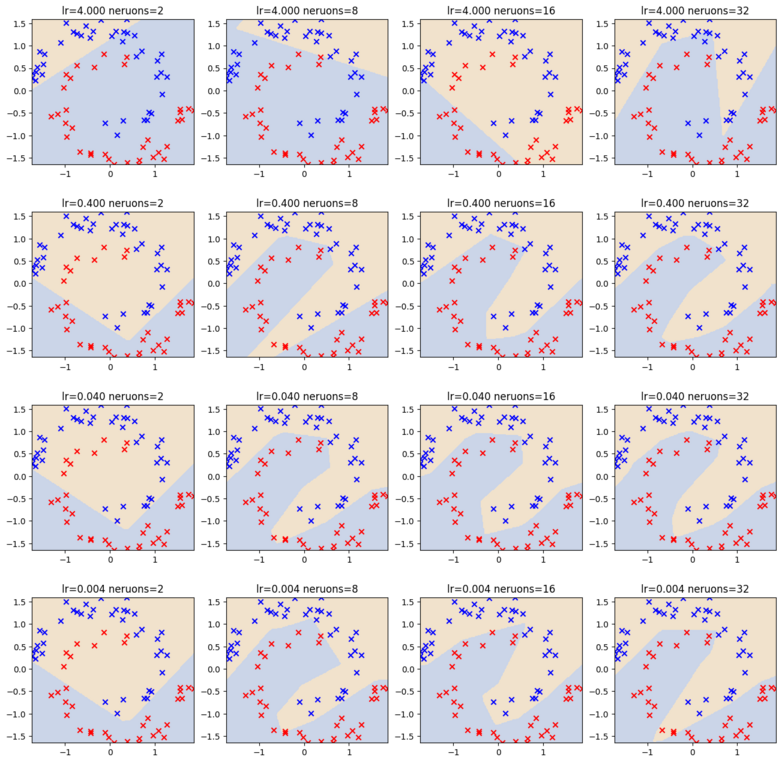

**Complete** the code below to plot the decision function for each setting in the grid:

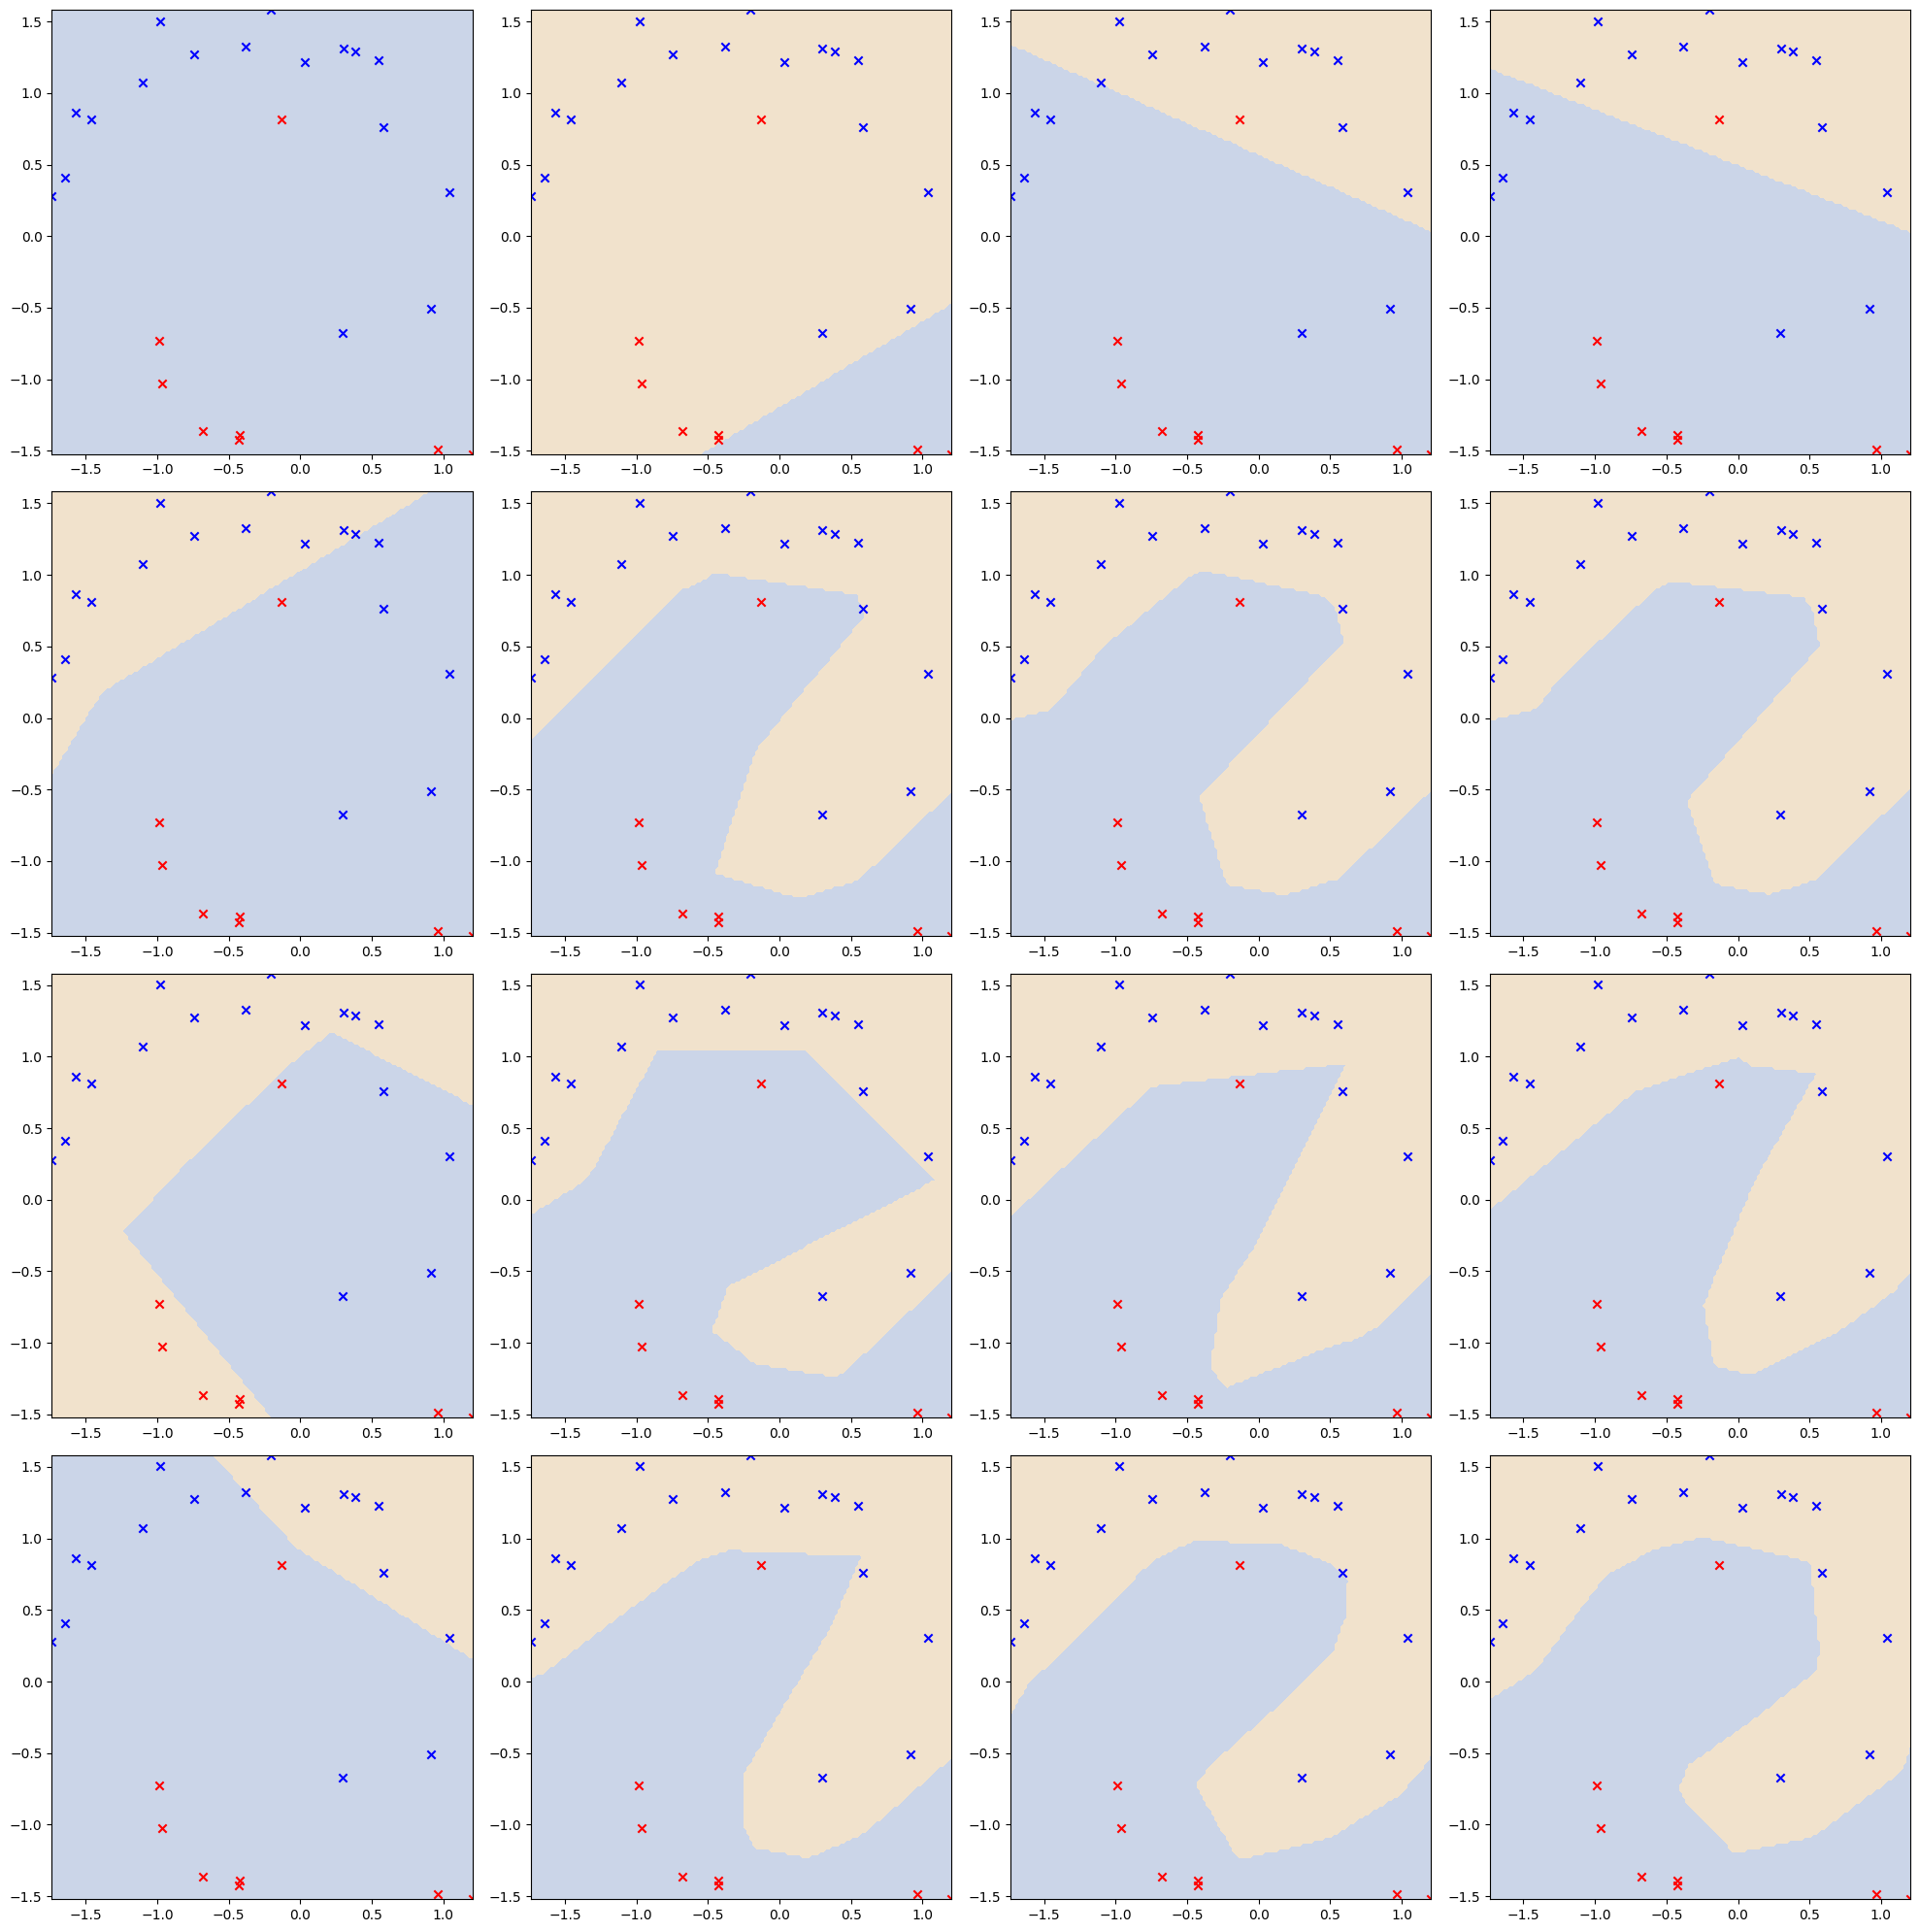

In [66]:
# Your code here. Aim for 9-13 lines.

plt.figure(figsize=(20, 20))

for i, (lr, neurons) in enumerate(zip(lr_grid.flatten(), neuron_grid.flatten())):
  plt.subplot(4, 4, i+1)

  mlp = MLPClassifier(hidden_layer_sizes=(neurons,),
                      learning_rate_init=lr,
                      max_iter=10_000,
                      random_state=42)
  mlp.fit(X_tr, y_tr)
  draw_dec_boundaries(X_valid, y_valid, mlp)
  draw_plot(X_valid, y_valid)

plt.tight_layout()
plt.show()

<div style="border-bottom: 3px solid black;"></div>

### Exercise 2.2 &mdash; Grid hyperparameter search

In this exercise, you should use the [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function to perform a grid hyperparameter search (use the same grid of hyperparameters from *Exercise 2.1*) with the use of 5-fold cross-validation.

In particular, you should do the following:
1. Create an **MLP** object.
2. Define the **param_grid** argument for **GridSearchCV**. This is a dictionary of the form *{ hyperparameter_name: array_of_possible_values }*. For example you could make a variable `param_grid = { 'learning_rate_init': ..., 'hidden_layer_sizes': ...}` where `...` are the arrays of values you created early on in Exercise 2.1.
3. Create a **GridSearchCV** object, passing your prototype MLP object and your param_grid as arguments.
  * Set **verbose=1**, this will tell the function to print out more information of the grid search, and helps you to understand.  
  * Use the **cv** parameter to specify 6-fold cross-validation
4. Call **fit** on the **GridSearchCV** object to perform the grid search. This will perform 6-fold cross-validation for every combination of (*learning_rate_init*, *hidden_layer_sizes*) in the grid you specified.
5. Plot the data and the best MLP model from the grid search (use the **GridSearchCV** object's **best_estimator_** attribute).

You should see the following prints:

```
best parameters: {'hidden_layer_sizes': 8, 'learning_rate_init': 0.4}
98.7% accuracy on validation sets (average)
```
and the following image:

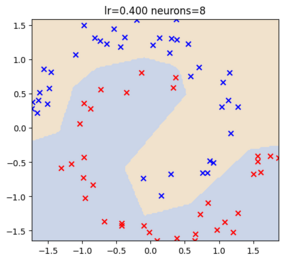

**Complete** the code below to perform grid search with scikit learn. This might take few minutes.

Fitting 6 folds for each of 16 candidates, totalling 96 fits


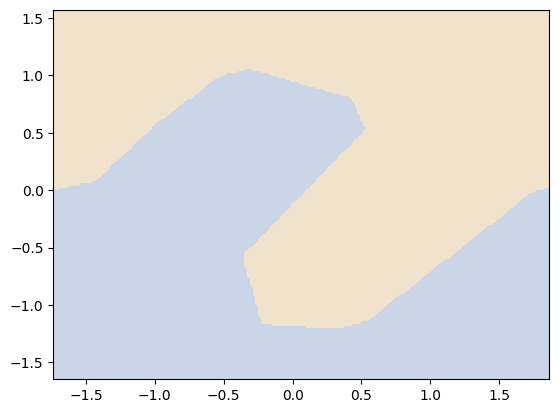

In [58]:
from sklearn.model_selection import GridSearchCV


# Instantiate an MLP (aim for 1 line)
mlp = MLPClassifier(max_iter=10_000, random_state=42)

# Parameter grid specification (dictionary, aim for 1 line)
learning_rates = np.array([4, 0.4, 0.04, 0.004])
neurons = np.array([2, 8, 16, 32])
param_grid = {'hidden_layer_sizes': neurons, 'learning_rate_init': learning_rates}

# Instantiate an GridSearchCV (aim for 1 line)
gridcv = GridSearchCV(mlp, param_grid, cv=6, verbose=1)

# Train with GridSearchCV aim for 1 line
gridcv.fit(X_train, y_train)

# Plot boundaries (aim for 2-3 lines)
best_mlp = gridcv.best_estimator_
draw_dec_boundaries(X_train, y_train, best_mlp)

# Optional: print the best set of parameters (aim for 1 line)

# Optional: print the accuracy with the best parameters (aim for 1 line)


You also have to to:
* print the validation score (accuracy, by default) of the best-performing hyperparameters by printing the **best_score_** attribute, and
* inspect the best parameters using the **best_params_** attribute.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

### Exercise 2.3 &mdash; Random hyperparameter search

Grid hyperparameter search can be seen as an exhaustive search approach to find the best model configuration. However, it is not necessary the best, especially in terms of computation efficiency. Thus, random hyperparameter search has been applied widely in various research studies.

**<u>Random hyperparameter search</u>** can be used to sample a random value from a grid or a specified distribution. To implement it, you can use [sklearn.model_selection.RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).
As before, you have to implement the followings steps:
1. Define a grid for the learning rate and the number of neurons where random sampling is performed. This time, we can use a larger grid such as:
 - lr: [1.0, 0.4, 0.1, 0.04, 0.01, 0.004, 0.001]
 - neurons: [2, 4, 8, 16, 32, 64, 128]
2. Initialize the RandomizedSearchCV object. Use n_iter=18. This way the algorithm will randomly sample 18 models. Use cv=6 as before.

3. Run the hyperparameter search with the `.fit` method.
4. Plot the training data with the boundaries.

You should see the following print:



```
Fitting 6 folds for each of 18 candidates, totalling 108 fits
best parameters: {'learning_rate_init': 0.04, 'hidden_layer_sizes': 128}
98.7% accuracy on validation sets (average)
```

and the following image:





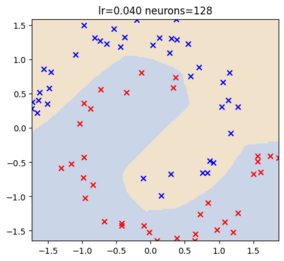

**Complete the code cell below** to implement a random hyperparameter search (the code will be very similar to that implemented in Exercise 2.2). For this exercise, a list of dictionaries is used which contains the learning rates and the hidden layer sizes. RandomSearchCV will sample those lists uniformly. Running the code might take few minutes.

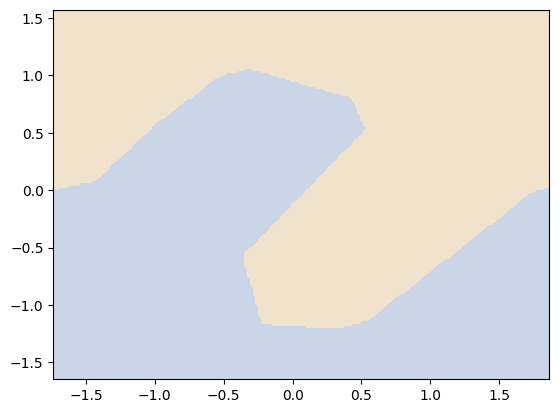

In [62]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

# Hparams gride specification (aim for 2 lines)
lr_grid = [1.0, 0.4, 0.1, 0.04, 0.01, 0.004, 0.001]
neurons_grid = [2, 4, 8, 16, 32, 64, 128]

# Hparams dictionary (aim for 1 line)
hparam_choices = {
    'learning_rate_init': lr_grid,
    'hidden_layer_sizes': [(n,) for n in neurons_grid]
}

# Instantiate RandomizedSearchCV (aim for 1)
randcv = RandomizedSearchCV(
    MLPClassifier(max_iter=10_000, random_state=42),
    param_distributions=hparam_choices,
    n_iter=18,
    cv=6,
    random_state=42
)

# Train with random seach (aim for 1 line)
randcv.fit(X_train, y_train)

# Plot data and boundaries (aim for 2-3 lines)
draw_dec_boundaries(X_train, y_train, randcv)


# Optional: print the best set of parameters (aim for 1 line)


# Optional: print the accuracy with the best parameters (aim for 1 line)


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

### Exercise 2.4 &mdash; Evaluate hyperparameter performance on held-out test data

After the hyperparameter search is completed and the final hyperparameters are chosen, you can now do the final evaluation on the model performance using a **held-out test set**. You explicitly held out a test set ($\mathbf{X}_\text{test}, \mathbf{y}_\text{test}$) in Exercise 1.2, so use that data here.

Using your *GridSearchCV* and *RandomSearchCV* objects from Exercises 2.2 and 2.3 respectively, print the training accuracy and test accuracy of the "best estimator" found by each.
* Use the **score** method on the search object to compute the accuracy on the training data and on the test data.

Your output should look like this:
```
grid search:
  100.0% train accuracy
  100.0% test accuracy
random search:
  100.0% train accuracy
  100.0% test accuracy
```
*Tip:* Remember that if you want to print a `%` symbol when formatting a string, you must put `%%` in the original string so that Python knows it's not the start of a format specification (like `%d` or `%.2f`).

**Complete** the code below to evaluate the hyperparameter performance on held-out test data:

In [69]:
# Compute the accuracy on training and test with the model found by gridsearch (aim for 2 lines)
grid_accuracy_train = gridcv.score(X_train, y_train)
grid_accuracy_test = gridcv.score(X_test, y_test)

# Print accuracy achieved with gridsearch (aim for 2 lines)
print(f"grid search:\n {grid_accuracy_train*100:.1f}% train accuracy")
print(f" {grid_accuracy_test*100:.1f}% test accuracy")


# Compute the accuracy on training and test with the model found by randomsearch (aim for 2 lines)
rand_accuracy_train = randcv.score(X_train, y_train)
rand_accuracy_test = randcv.score(X_test, y_test)

# Print accuracy achieved with randomsearch (aim for 2 lines)
print(f"random search:\n {rand_accuracy_train*100:.1f}% train accuracy")
print(f" {rand_accuracy_test*100:.1f}% test accuracy")


grid search:
 100.0% train accuracy
 100.0% test accuracy
random search:
 100.0% train accuracy
 100.0% test accuracy


Notice that RandomSearchCV does not try all the values in the list of dictionaries rather a certain subset, while GridSearchCV exhaustively tries all the values. In the end RandomSearchCV obtains a set of parameters that performs better than GridSearchCV!

In this lab, we focussed on scikit learn. *What I can do with PyTorch?* PyTorch does not have its internal tool for hyperparameter optimization. However, you can use excellent external tools such as [Orion](https://github.com/Epistimio/orion).

That's all!